In [1]:
import time
import pandas as pd
from multiprocessing import Pool
import math
import os
import shutil
import matplotlib.pyplot as plt
from scipy.io import readsav
import glob
import statistics
from aetherpy.io import read_routines
from math import cos, radians, sin, sqrt
from scipy import spatial, signal
from glob import glob
from datetime import datetime
from datetime import timedelta
from struct import unpack
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from pylab import cm
import fnmatch

from aetherpy.io import read_routines as rr

import sys

from scipy.interpolate import LinearNDInterpolator, interp1d

from utility_programs.read_routines import SAMI
from utility_programs.filters import make_fits

import xarray as xr
import importlib
import gc

import cartopy.crs as ccrs

import xesmf as xe

## SICK

now do SAMI. Will be weird cuz we have some post-processed files and some not-processed files

In [2]:
sami_data_path = "/petastore/phil/GITM/cheyenne_runs/FullAmp/sami-gitm-coupled/"

In [3]:

sami_og_vars = {
    'deneu.dat': 'edens', }

geo_grid_files = {
    'lat': 'glatu.dat', 'lon': 'glonu.dat', 'alt': 'zaltu.dat',
}

In [4]:
nz, nf, nlt, nt = SAMI.get_grid_elems_from_parammod(sami_data_path)
times = SAMI.make_times(nt, sami_data_path, datetime(2011, 5, 20))

In [5]:
grid = {}

for f in geo_grid_files:
    file = open(os.path.join(sami_data_path, geo_grid_files[f]), 'rb')
    raw = np.fromfile(file, dtype='float32')[1:-1].copy()
    file.close()

    grid[f] = raw.reshape(nlt, nf, nz).copy()

In [52]:
gridnames = ('loc')
ds = xr.Dataset(
    coords=dict(
        time=(('time'), times),
        alt=(gridnames, grid['alt'].flatten()),
        lon=(gridnames, grid['lon'].flatten()),
        lat=(gridnames, grid['lat'].flatten()),


        # mlt=('mlt', np.arange(nlt)),
        # nf = (('nf'), np.arange(nf)),
        # nz = (('nz'), np.arange(nz)),
    )
)

In [53]:
dimnames = ('time', 'loc')

for fname in sami_og_vars.keys():
    curr_arr = np.zeros((len(times), nlt * nf * nz))
    with open(os.path.join(sami_data_path, fname), 'rb') as f:
        t_ins = 0
        for t in range(len(times)):
            raw = np.fromfile(f, dtype='float32',
                              count=(nz*nf*nlt)+2)[1:-1]
            curr_arr[t_ins] = raw  # .reshape(nlt, nf, nz).copy()
            t_ins += 1

        ds[sami_og_vars[fname]] = (dimnames, curr_arr)

In [58]:
target_alt = 400
thresh = 10

ds_a400 = ds.where((np.abs(ds.alt - target_alt) < thresh), drop=True).isel(
    time=425).drop_vars(['time', 'alt'])
ds_a400

<xarray.Dataset>
Dimensions:  (loc: 13460)
Coordinates:
    lon      (loc) float32 290.5 290.5 290.4 290.4 ... 134.5 279.2 128.7 278.2
    lat      (loc) float32 -15.81 -15.55 -15.29 -15.03 ... 77.04 -76.8 79.97
Dimensions without coordinates: loc
Data variables:
    edens    (loc) float64 3.773e+05 3.63e+05 3.504e+05 ... 2.856e+05 4.426e+05

In [59]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 2.0)),
        "lon": (["lon"], np.arange(0, 360, 5)),
    }
)

In [60]:
regridder = xe.Regridder(ds_a400, ds_out, "bilinear", periodic=True)

In [ ]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_22x22_90x72_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (22, 22) 
Output grid shape:          (90, 72) 
Periodic in longitude?      True

In [3]:
# importlib.reload(SAMI)
# SAMI.process_bins_to_netcdf(sami_path, datetime(2011, 5, 20),
#                             progress_bar=True, split_by_var=True,
#                             split_by_time=True, whole_file=True,
#                             low_mem=True, OVERWRITE=False,)

In [4]:
ds = SAMI.auto_read(sami_path)

In [5]:
ds

<xarray.Dataset>
Dimensions:         (time: 624, nlt: 80, nf: 72, nz: 256)
Coordinates:
  * time            (time) datetime64[ns] 2011-05-20 ... 2011-05-22T03:55:00
    mlat            (nlt, nf, nz) float32 ...
    mlon            (nlt, nf, nz) float32 ...
    malt            (nlt, nf, nz) float32 ...
    glat            (nlt, nf, nz) float32 ...
    glon            (nlt, nf, nz) float32 ...
    alt             (nlt, nf, nz) float32 ...
Dimensions without coordinates: nlt, nf, nz
Data variables: (12/25)
    edens           (time, nlt, nf, nz) float64 ...
    h+dens          (time, nlt, nf, nz) float64 ...
    o+dens          (time, nlt, nf, nz) float64 ...
    n+odens         (time, nlt, nf, nz) float64 ...
    o2+dens         (time, nlt, nf, nz) float64 ...
    he+dens         (time, nlt, nf, nz) float64 ...
    ...              ...
    h+vel_parallel  (time, nlt, nf, nz) float64 ...
    o+vel_parallel  (time, nlt, nf, nz) float64 ...
    mer_exb         (time, nlt, nf, nz) float64 ...
    zon_exb         (time, nlt, nf, nz) float64 ...
    zon_neut        (time, nlt, nf, nz) float64 ...
    mer_neut        (time, nlt, nf, nz) float64 ...

In [13]:
# Chnange from nlt, nf, nz index to mlon, mlat, alt
c = b.copy()

In [14]:
c

<xarray.Dataset>
Dimensions:         (nlt: 80, nf: 72, nz: 256)
Coordinates:
    time            datetime64[ns] 2011-05-21T13:40:00
    mlat            (nlt, nf, nz) float32 ...
    mlon            (nlt, nf, nz) float32 ...
    malt            (nlt, nf, nz) float32 ...
    glat            (nlt, nf, nz) float32 ...
    glon            (nlt, nf, nz) float32 ...
    alt             (nlt, nf, nz) float32 80.02 80.03 80.05 ... 89.94 87.09 84.4
Dimensions without coordinates: nlt, nf, nz
Data variables: (12/25)
    edens           (nlt, nf, nz) float64 ...
    h+dens          (nlt, nf, nz) float64 ...
    o+dens          (nlt, nf, nz) float64 ...
    n+odens         (nlt, nf, nz) float64 ...
    o2+dens         (nlt, nf, nz) float64 ...
    he+dens         (nlt, nf, nz) float64 ...
    ...              ...
    h+vel_parallel  (nlt, nf, nz) float64 ...
    o+vel_parallel  (nlt, nf, nz) float64 ...
    mer_exb         (nlt, nf, nz) float64 ...
    zon_exb         (nlt, nf, nz) float64 ...
    zon_neut        (nlt, nf, nz) float64 ...
    mer_neut        (nlt, nf, nz) float64 ...

In [15]:
np.sum(np.isnan(ds.edens.values)) - np.product(ds.edens.shape)

-920125440

In [16]:
c

<xarray.Dataset>
Dimensions:         (nlt: 80, nf: 72, nz: 256)
Coordinates:
    time            datetime64[ns] 2011-05-21T13:40:00
    mlat            (nlt, nf, nz) float32 ...
    mlon            (nlt, nf, nz) float32 ...
    malt            (nlt, nf, nz) float32 ...
    glat            (nlt, nf, nz) float32 ...
    glon            (nlt, nf, nz) float32 ...
    alt             (nlt, nf, nz) float32 80.02 80.03 80.05 ... 89.94 87.09 84.4
Dimensions without coordinates: nlt, nf, nz
Data variables: (12/25)
    edens           (nlt, nf, nz) float64 ...
    h+dens          (nlt, nf, nz) float64 ...
    o+dens          (nlt, nf, nz) float64 ...
    n+odens         (nlt, nf, nz) float64 ...
    o2+dens         (nlt, nf, nz) float64 ...
    he+dens         (nlt, nf, nz) float64 ...
    ...              ...
    h+vel_parallel  (nlt, nf, nz) float64 ...
    o+vel_parallel  (nlt, nf, nz) float64 ...
    mer_exb         (nlt, nf, nz) float64 ...
    zon_exb         (nlt, nf, nz) float64 ...
    zon_neut        (nlt, nf, nz) float64 ...
    mer_neut        (nlt, nf, nz) float64 ...

In [19]:
e = c.isel(nlt=30)

In [20]:
e = e.where(e.alt < 1200, drop='True')

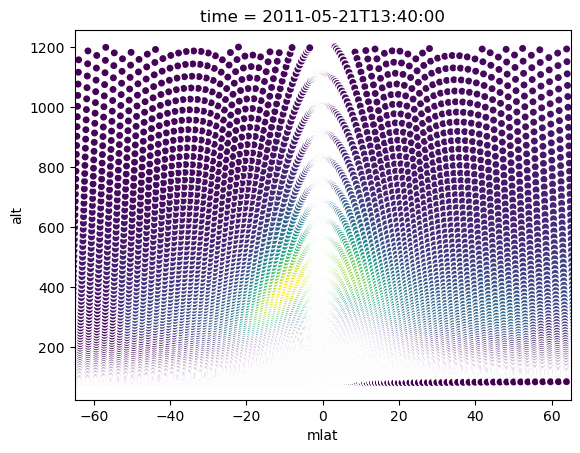

In [29]:
e.plot.scatter(x='mlat', y='alt', c=e.edens.where(e.alt < 1200))
plt.xlim(-65, 65)
plt.show()

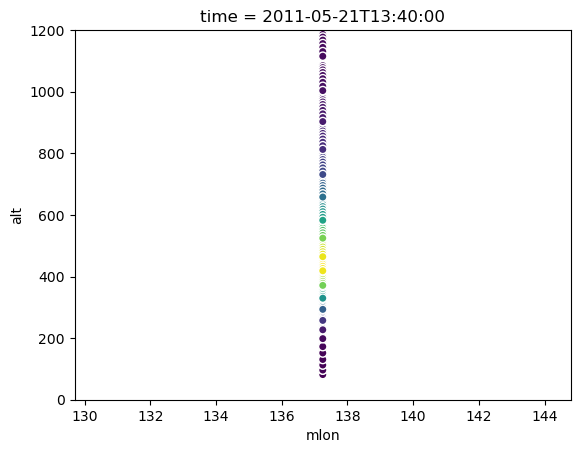

In [28]:
e.plot.scatter(x='mlon', y='alt', c=e.edens.where(
    np.abs(e.mlat.values - 5) < 2))
plt.ylim(0, 1200)
plt.show()

In [31]:
eds = SAMI.auto_read(sami_path, cols='edens')
glats = np.arange(-90, 90, 1)
glons = np.arange(-180, 180, 4)
alts = np.arange(100, 1200.01, 100)
out_ds_grid = xr.Dataset(coords={'lat': glats, 'lon': glons, 'alt': alts})

In [32]:
eds

<xarray.Dataset>
Dimensions:  (time: 624, nlt: 80, nf: 72, nz: 256)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-20 ... 2011-05-22T03:55:00
    mlat     (nlt, nf, nz) float32 ...
    mlon     (nlt, nf, nz) float32 ...
    malt     (nlt, nf, nz) float32 ...
    glat     (nlt, nf, nz) float32 ...
    glon     (nlt, nf, nz) float32 ...
    alt      (nlt, nf, nz) float32 ...
Dimensions without coordinates: nlt, nf, nz
Data variables:
    edens    (time, nlt, nf, nz) float64 ...

In [33]:
out_ds_grid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 90, alt: 12)
Coordinates:
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 -180 -176 -172 -168 -164 -160 ... 160 164 168 172 176
  * alt      (alt) float64 100.0 200.0 300.0 400.0 ... 1e+03 1.1e+03 1.2e+03
Data variables:
    *empty*

In [35]:
lat = eds.glat.values.flatten()
lon = eds.glon.values.flatten()
alt = eds.alt.values.flatten()
time = eds.time.values.flatten()
edens = eds.edens.values.reshape([len(time), len(lat)])

In [36]:
edens.shape

(624, 1474560)

In [37]:
len(lon)

1474560

In [38]:
ds_new = xr.Dataset(coords={'time': time, 'location': np.arange(len(lon))},
                    data_vars={'alt': (['location'], alt),
                               'edens': (['time', 'location'], edens),
                               'lat': (['location'], lat),
                               'lon': (['location'], lon),
                               })

In [39]:
ds_new

<xarray.Dataset>
Dimensions:   (location: 1474560, time: 624)
Coordinates:
  * time      (time) datetime64[ns] 2011-05-20 ... 2011-05-22T03:55:00
  * location  (location) int64 0 1 2 3 4 ... 1474556 1474557 1474558 1474559
Data variables:
    alt       (location) float32 80.02 80.03 80.05 80.06 ... 89.94 87.09 84.4
    edens     (time, location) float64 5.619 5.619 5.471 5.424 ... 0.0 0.0 0.0
    lat       (location) float32 -13.74 -13.74 -13.74 ... 80.04 80.04 80.04
    lon       (location) float32 290.3 290.3 290.3 290.3 ... 277.6 277.6 277.6

In [41]:
import esmpy

In [85]:
src = esmpy.LocStream(1474560, coord_sys=esmpy.CoordSys.SPH_DEG, )
src['ESMF:Lon'] = lon
src['ESMF:Lat'] = lat
# conver alt from km above surface to rE from center of earth
src['ESMF:Alt'] = (alt + 6371) * 1000
srcfield = esmpy.Field(src)
srcfield.data[...] = edens[110]

In [86]:
srcfield

Field:
    name = None
    type = <TypeKind.R8: 6>
    rank = 1
    extra dimensions = 0
    staggerloc = <StaggerLoc.CENTER: 0>
    lower bounds = array([0], dtype=int32)
    upper bounds = array([1474560], dtype=int32)
    extra bounds = None
    data = array([ 7.13824749,  7.13824749,  5.65443945, ..., 79.43428802,
       29.59856415, 29.59856415])
    grid = 
LocStream:
    name = None 
    lower_bounds = array([0], dtype=int32) 
    upper_bounds = array([1474560], dtype=int32) 
    keys = dict_items([('ESMF:Lon', array([290.3 , 290.3 , 290.3 , ..., 277.59, 277.58, 277.58], dtype=float32)), ('ESMF:Lat', array([-13.74, -13.74, -13.74, ...,  80.04,  80.04,  80.04], dtype=float32)), ('ESMF:Alt', array([6451020., 6451030., 6451050., ..., 6460940., 6458090., 6455400.],
      dtype=float32))]) 

)

In [87]:
glats = np.arange(-90, 90, 1)
glons = np.arange(-180, 180, 4)
alts = np.arange(100, 1200.01, 100)

glonout = []
glatout = []
altout = []
for o in glons:
    for l in glats:
        for a in alts:
            glonout.append(o)
            glatout.append(l)
            altout.append(a)

glonout = np.array(glonout).reshape([len(glons), len(glats), len(alts)])
glatout = np.array(glatout).reshape([len(glons), len(glats), len(alts)])
altout = np.array(altout).reshape([len(glons), len(glats), len(alts)])

In [88]:
del dsts, dstfield

In [89]:
dsts = esmpy.Grid(np.array([len(glons), len(glats), len(alts)]),
                  coord_sys=esmpy.CoordSys.SPH_DEG,
                  staggerloc=[esmpy.StaggerLoc.CENTER,
                              esmpy.StaggerLoc.CENTER,
                              esmpy.StaggerLoc.CENTER])


longitm = dsts.get_coords(0)
latgitm = dsts.get_coords(1)
altgitm = dsts.get_coords(2)

longitm[...] = glonout
latgitm[...] = glatout
altgitm[...] = altout


dstfield = esmpy.Field(dsts)

In [93]:
esmpy.MeshElemType

<enum 'MeshElemType'>

In [90]:
regridder = esmpy.Regrid(
    srcfield, dstfield, regrid_method=esmpy.RegridMethod.PATCH)

ValueError: ESMC_FieldRegridStore failed with rc = 6. Please check the log files (named "*ESMF_LogFile").

In [82]:
pwd

'/home/axb170054/SAMI3-GITM-python'